In [1]:
import pandas as pd
import numpy as np
import random as rand
import tqdm
import networkx as nx
import pickle as pkl
import gower
import matplotlib.pyplot as plt
import methods
from methods import topK, findGroups, prototype, ranking, getAttributes, Q, Q2, Discovery

# First create a nx.Graph() object here. This example uses the graph from the Chemistry dataset. Replace this code to generate your own.

In [2]:
with open('graph_349519.pkl', 'rb') as input:
    graph = pkl.load(input)

# Extracting data
edge_index = graph['edge_index']
num_nodes = graph['num_nodes']

# Create a networkx graph
G = nx.Graph()

# Add nodes
G.add_nodes_from(range(num_nodes))

# Add edges
edges = list(zip(edge_index[0], edge_index[1]))
G.add_edges_from(edges)

# Create a LU table
Create a look up table with numerical columns that represent attributes, and a column 'target' with the target variable (binary). Please use the names of the nodes in the graph as index for the lookup table.

In [3]:
# Create a lookup table for gower distances
attributes = graph['node_feat']
lu = pd.DataFrame(attributes)
lu['target'] = lu[0] >= 6

In [4]:
# findGroups(G, k, lu)
# Where G is the graph, k is the top-k number, and lu is the lookup table (with only attributes), make sure that there is a 'target' column
# in lu with the binary target for the subgroup. Additionally, the index of the lookup table should represent the node name

result = findGroups(G, 20, lu)

  0%|          | 0/332 [00:00<?, ?it/s]

100%|██████████| 332/332 [01:00<00:00,  5.52it/s]


In [5]:
result

,rho,sigma,q,ranks,reference,subgroup
46,9,3,0.320750,"[(46, False), (44, False), (47, False), (45, T...","[46, 44, 47, 45, 42, 49, 48, 41, 43]","[46, 44, 47]"
28,14,5,0.230508,"[(28, True), (27, False), (26, True), (29, Fal...","[28, 27, 26, 29, 33, 25, 30, 22, 20, 34, 23, 2...","[28, 27, 26, 29, 33]"
253,13,5,0.228987,"[(253, False), (255, True), (254, True), (247,...","[253, 255, 254, 247, 246, 248, 256, 244, 261, ...","[253, 255, 254, 247, 246]"
35,13,5,0.228987,"[(35, True), (34, False), (33, True), (36, Fal...","[35, 34, 33, 36, 41, 37, 32, 29, 27, 38, 42, 3...","[35, 34, 33, 36, 41]"
147,13,5,0.228987,"[(147, False), (149, True), (148, True), (141,...","[147, 149, 148, 141, 140, 142, 150, 138, 155, ...","[147, 149, 148, 141, 140]"
11,11,7,0.207201,"[(11, True), (12, False), (8, False), (13, Tru...","[11, 12, 8, 13, 6, 9, 14, 5, 19, 7, 10]","[11, 12, 8, 13, 6, 9, 14]"
167,5,3,0.206559,"[(167, True), (168, False), (166, False), (169...","[167, 168, 166, 169, 170]","[167, 168, 166]"
268,5,3,0.206559,"[(268, True), (269, False), (267, False), (270...","[268, 269, 267, 270, 271]","[268, 269, 267]"
45,9,4,0.203704,"[(45, True), (44, False), (46, False), (42, Fa...","[45, 44, 46, 42, 41, 43, 47, 49, 48]","[45, 44, 46, 42]"
272,16,5,0.195656,"[(272, False), (274, True), (273, True), (264,...","[272, 274, 273, 264, 263, 265, 275, 261, 276, ...","[272, 274, 273, 264, 263]"


In [11]:
output = pd.DataFrame()

output['Prototype'] = result.index
output.index = result.index
output['Rho'] = result['rho']
output['Sigma'] = result['sigma']
output['Q'] = result['q']
output[0:5].to_latex()

'\\begin{tabular}{lrrrr}\n\\toprule\n & Prototype & Rho & Sigma & Q \\\\\n\\midrule\n46 & 46 & 9 & 3 & 0.320750 \\\\\n28 & 28 & 14 & 5 & 0.230508 \\\\\n253 & 253 & 13 & 5 & 0.228987 \\\\\n35 & 35 & 13 & 5 & 0.228987 \\\\\n147 & 147 & 13 & 5 & 0.228987 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [7]:
testranks

[(46, False),
 (44, False),
 (47, False),
 (45, True),
 (42, False),
 (49, True),
 (48, True),
 (41, True),
 (43, True),
 (36, False),
 (37, False),
 (34, False),
 (38, False),
 (33, True),
 (35, True),
 (32, False),
 (29, False),
 (40, True),
 (39, True),
 (30, False),
 (31, False),
 (27, False),
 (26, True),
 (28, True),
 (25, False),
 (22, False),
 (23, False),
 (24, False),
 (20, False),
 (19, True),
 (21, True),
 (14, False),
 (15, False),
 (12, False),
 (16, False),
 (11, True),
 (13, True),
 (17, False),
 (18, False),
 (8, False),
 (9, False),
 (6, False),
 (10, True),
 (5, True),
 (7, True),
 (4, False),
 (2, False),
 (50, False),
 (1, False),
 (3, False),
 (52, True),
 (51, True),
 (0, False),
 (53, False),
 (54, False),
 (58, False),
 (55, False),
 (60, True),
 (59, True),
 (61, False),
 (57, True),
 (56, True),
 (62, False),
 (66, False),
 (63, False),
 (68, True),
 (67, True),
 (64, False),
 (65, False),
 (69, False),
 (329, False),
 (70, False),
 (330, False),
 (331, True)

In [8]:
Discovery(testranks, G, lu)

[(46, False), (44, False), (47, False), (45, True), (42, False)]
0.02203048896307186 5
[(46, False), (44, False), (47, False), (45, True), (42, False), (49, True)]
[(46, False), (44, False), (47, False), (45, True), (42, False), (49, True), (48, True)]
[(46, False), (44, False), (47, False), (45, True), (42, False), (49, True), (48, True), (41, True)]
[(46, False), (44, False), (47, False), (45, True), (42, False), (49, True), (48, True), (41, True), (43, True)]
0.028983936121775668 9
[(46, False), (44, False), (47, False), (45, True), (42, False), (49, True), (48, True), (41, True), (43, True), (36, False)]
[(46, False), (44, False), (47, False), (45, True), (42, False), (49, True), (48, True), (41, True), (43, True), (36, False), (37, False)]
[(46, False), (44, False), (47, False), (45, True), (42, False), (49, True), (48, True), (41, True), (43, True), (36, False), (37, False), (34, False)]
[(46, False), (44, False), (47, False), (45, True), (42, False), (49, True), (48, True), (41,

(9,
 4,
 0.20370370370370372,
 [(46, False),
  (44, False),
  (47, False),
  (45, True),
  (42, False),
  (49, True),
  (48, True),
  (41, True),
  (43, True),
  (36, False),
  (37, False),
  (34, False),
  (38, False),
  (33, True),
  (35, True),
  (32, False),
  (29, False),
  (40, True),
  (39, True),
  (30, False),
  (31, False),
  (27, False),
  (26, True),
  (28, True),
  (25, False),
  (22, False),
  (23, False),
  (24, False),
  (20, False),
  (19, True),
  (21, True),
  (14, False),
  (15, False),
  (12, False),
  (16, False),
  (11, True),
  (13, True),
  (17, False),
  (18, False),
  (8, False),
  (9, False),
  (6, False),
  (10, True),
  (5, True),
  (7, True),
  (4, False),
  (2, False),
  (50, False),
  (1, False),
  (3, False),
  (52, True),
  (51, True),
  (0, False),
  (53, False),
  (54, False),
  (58, False),
  (55, False),
  (60, True),
  (59, True),
  (61, False),
  (57, True),
  (56, True),
  (62, False),
  (66, False),
  (63, False),
  (68, True),
  (67, True),
 

In [13]:
out.to_csv('subgroups_graph_349519.csv')

In [9]:
lu['color'] = 'Skyblue'
lu.loc[lu['target'], 'color'] = 'Red'

In [31]:
# CHANGE THIS TO MAKE THE SUBGROUPS VISIBLE
def changeValue(rho, sigma, ranks):
    referencegroup = [x[0] for x in ranks[0:rho]]
    subgroup = [x[0] for x in ranks[0:sigma]]

    lu.loc[referencegroup, 'color'] = 'Green'

    return None


lu['size'] = 500

In [32]:
lu['color'] = 'gray'
lu['size'] = 500

rho, sigma, q, ranks = out.loc[46].tolist()
changeValue(rho, sigma, ranks)

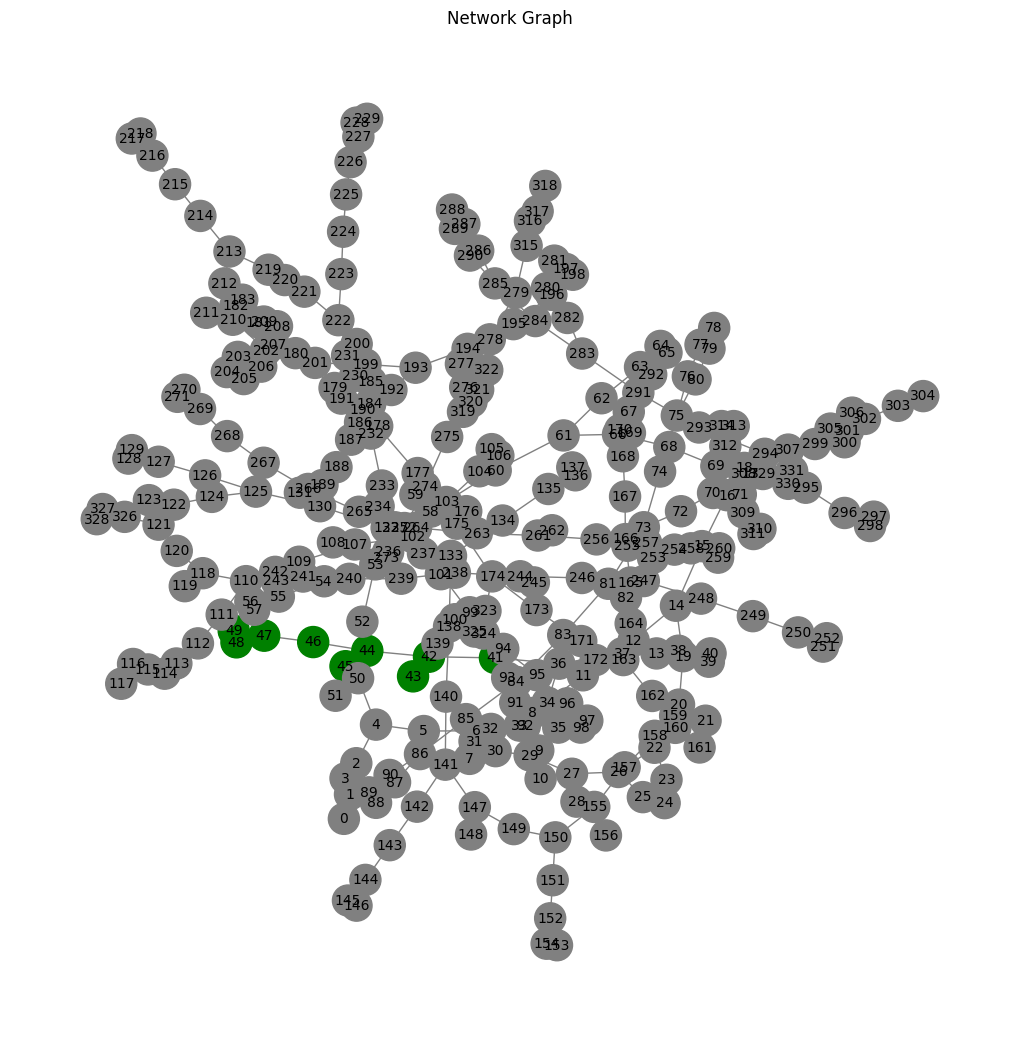

In [33]:
# Plot the graph
plt.figure(figsize=(10, 10))
nx.draw(G, with_labels=True, node_color=lu['color'], edge_color='gray', node_size=lu['size'], font_size=10)
plt.title("Network Graph")
plt.show()